In [ ]:
import pandas as pd
import numpy as np
import string
from string import digits
import matplotlib.pyplot as plt
%matplotlib inline
import re
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input, LSTM, Embedding, Dense, Bidirectional
from keras.models import Model
import nltk

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
lines= pd.read_table('/content/gdrive/MyDrive/Deep Learning All Batches/UNITWISE NOTES/Unit4-5 SEQUENTIAL MODEL/LSTM Lab /mar.txt', names=['eng', 'mar', 'noise'])

In [ ]:
lines.shape

(46995, 3)

**Clean the source and target sentences.**

In [ ]:
# Lowercase all characters
lines.eng=lines.eng.apply(lambda x: x.lower())
lines.mar=lines.mar.apply(lambda x: x.lower())

In [ ]:
# Remove quotes
lines.eng=lines.eng.apply(lambda x: re.sub("'", '', x))
lines.mar=lines.mar.apply(lambda x: re.sub("'", '', x))

In [ ]:
exclude = set(string.punctuation) # Set of all special characters
# Remove all the special characters
lines.eng=lines.eng.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))
lines.mar=lines.mar.apply(lambda x: ''.join(ch for ch in x if ch not in exclude))

In [ ]:
# Remove all numbers from text
remove_digits = str.maketrans('', '', digits)
lines.eng=lines.eng.apply(lambda x: x.translate(remove_digits))
lines.mar = lines.mar.apply(lambda x: re.sub("[२३०८१५७९४६]", "", x))

In [ ]:
# Remove extra spaces
lines.eng=lines.eng.apply(lambda x: x.strip())
lines.mar=lines.mar.apply(lambda x: x.strip())
lines.eng=lines.eng.apply(lambda x: re.sub(" +", " ", x))
lines.mar=lines.mar.apply(lambda x: re.sub(" +", " ", x))

In [ ]:
# Add start and end tokens to target sequences
lines.mar = lines.mar.apply(lambda x : 'START_ '+ x + ' _END')

In [ ]:
lines.sample(5)

,eng,mar,noise
9727,wheres my brandy,START_ माझी ब्रँडी कुठेय _END,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
10319,he raised his hand,START_ त्याने त्याचा हात वर केला _END,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
444,stay calm,START_ शांत राहा _END,CC-BY 2.0 (France) Attribution: tatoeba.org #7...
15821,its almost midnight,START_ जवळजवळ मध्यरात्र झाली आहे _END,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
30484,i dont read the newspapers,START_ मी वृत्तपत्र वाचत नाही _END,CC-BY 2.0 (France) Attribution: tatoeba.org #9...


Create a set of unique words both for source and target language from the dataset and sort them alphabetically

In [ ]:
# Vocabulary of English
all_eng_words=set()
for eng in lines.eng:
    for word in eng.split():
        if word not in all_eng_words:
            all_eng_words.add(word)

# Vocabulary of Marathi
all_marathi_words=set()
for mar in lines.mar:
    for word in mar.split():
        if word not in all_marathi_words:
            all_marathi_words.add(word)

In [ ]:
# Max Length of source sequence
lenght_list=[]
for l in lines.eng:
    lenght_list.append(len(l.split(' ')))
max_length_src = np.max(lenght_list)
max_length_src

34

In [ ]:
# Max Length of target sequence
lenght_list=[]
for l in lines.mar:
    lenght_list.append(len(l.split(' ')))
max_length_tar = np.max(lenght_list)
max_length_tar

37

In [ ]:
input_words = sorted(list(all_eng_words))
target_words = sorted(list(all_marathi_words))
num_encoder_tokens = len(all_eng_words)+1
num_decoder_tokens = len(all_marathi_words)+1
num_encoder_tokens, num_decoder_tokens

(5839, 14393)

In [ ]:
num_decoder_tokens += 1 # For zero padding
num_decoder_tokens

14394

Create a word to index dictionary and an index to word dictionary for all unique source and target words in the dataset.
Size of the word to vector will be based on the length of the source and target vocabulary

In [ ]:
input_token_index = dict([(word, i+1) for i, word in enumerate(input_words)])
target_token_index = dict([(word, i+1) for i, word in enumerate(target_words)])
print(input_token_index)
print(target_token_index)

{'a': 1, 'abbreviation': 2, 'ability': 3, 'able': 4, 'about': 5, 'above': 6, 'abroad': 7, 'absent': 8, 'absolute': 9, 'absolutely': 10, 'absorb': 11, 'accent': 12, 'accept': 13, 'acceptable': 14, 'accepted': 15, 'access': 16, 'accessible': 17, 'accident': 18, 'accidentally': 19, 'accomplices': 20, 'according': 21, 'accordion': 22, 'account': 23, 'accusations': 24, 'accused': 25, 'accusing': 26, 'accustomed': 27, 'ace': 28, 'aces': 29, 'acetone': 30, 'ache': 31, 'aches': 32, 'achille': 33, 'achilles': 34, 'aching': 35, 'acid': 36, 'acknowledged': 37, 'acquired': 38, 'acres': 39, 'across': 40, 'act': 41, 'acted': 42, 'acting': 43, 'action': 44, 'activist': 45, 'actor': 46, 'actors': 47, 'actress': 48, 'acts': 49, 'actual': 50, 'actually': 51, 'add': 52, 'added': 53, 'addict': 54, 'addicted': 55, 'addition': 56, 'additional': 57, 'addon': 58, 'address': 59, 'adds': 60, 'administrative': 61, 'admire': 62, 'admit': 63, 'admitted': 64, 'adopt': 65, 'adopted': 66, 'adultery': 67, 'advance': 6

In [ ]:
reverse_input_char_index = dict((i, word) for word, i in input_token_index.items())
reverse_target_char_index = dict((i, word) for word, i in target_token_index.items())
print(reverse_target_char_index)

{1: '10', 2: '100', 3: '300', 4: 'START_', 5: '_END', 6: 'a', 7: 'b', 8: 'h₂o', 9: 'ntt', 10: 'uk', 11: 'अ', 12: 'अँकरेजमार्गे', 13: 'अँजिलीस', 14: 'अँटीव्हायरस', 15: 'अँड', 16: 'अँडी', 17: 'अँडीजमधल्या', 18: 'अँब्युलन्स', 19: 'अंक', 20: 'अंकांनी', 21: 'अंकारा', 22: 'अंकारात', 23: 'अंग', 24: 'अंगठ्या', 25: 'अंगरक्षकांची', 26: 'अंगाला', 27: 'अंगोला', 28: 'अंघोळ', 29: 'अंठ्यांपेक्षा', 30: 'अंड', 31: 'अंडरवेअर', 32: 'अंडी', 33: 'अंडींचा', 34: 'अंडीसुद्धा', 35: 'अंड्यांवर', 36: 'अंड्यांसहित', 37: 'अंत', 38: 'अंतर', 39: 'अंतराळयात्री', 40: 'अंतराळयान', 41: 'अंतराळयानाचं', 42: 'अंतराळयानातून', 43: 'अंतराळवीर', 44: 'अंतराळात', 45: 'अंतरित', 46: 'अंतिम', 47: 'अंदाज', 48: 'अंदाजे', 49: 'अंधार', 50: 'अंधाराची', 51: 'अंधारात', 52: 'अंमलात', 53: 'अंशांकित', 54: 'अकरा', 55: 'अकरावीत', 56: 'अकल्पनीय', 57: 'अकाउंट', 58: 'अकाउंटमध्ये', 59: 'अकॉर्डियन', 60: 'अक्कलदाढ', 61: 'अक्वॅरियममध्ये', 62: 'अक्षर', 63: 'अक्षरं', 64: 'अक्षरांनी', 65: 'अक्षरांमध्ये', 66: 'अक्षरे', 67: 'अखाद्य', 68: 'अखिलेउस', 69: 'अ

In [ ]:
lines = shuffle(lines)
lines.head(10)

,eng,mar,noise
44043,he is the very man that i have waited for,START_ होच तो पुरुष ज्याची मी वाट पाहत होते _END,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
19183,what else do you want,START_ तुम्हाला अजून काय हवं आहे _END,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
29661,we cant blame anyone else,START_ आपण इतर कोणालाही दोष देऊ शकत नाही _END,CC-BY 2.0 (France) Attribution: tatoeba.org #4...
20092,i dont know everybody,START_ मी सर्वांना ओळखत नाही _END,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
33921,i just dont know you anymore,START_ मी आता तुम्हाला ओळखत नाही _END,CC-BY 2.0 (France) Attribution: tatoeba.org #8...
32745,she died yesterday afternoon,START_ त्या काल दुपारी मेल्या _END,CC-BY 2.0 (France) Attribution: tatoeba.org #3...
6193,dont yell at me,START_ माझ्यावर ओरडू नका _END,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
18206,it was saturday night,START_ शनिवारची रात्र होती _END,CC-BY 2.0 (France) Attribution: tatoeba.org #2...
10561,i laughed out loud,START_ मी जोरात हसलो _END,CC-BY 2.0 (France) Attribution: tatoeba.org #1...
43501,we dont know what tom is going to find,START_ टॉमला काय सापडणार आहे हे आपल्याला माहीत...,CC-BY 2.0 (France) Attribution: tatoeba.org #8...


In [ ]:
# Train - Test Split
X, y = lines.eng, lines.mar
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)
X_train.shape, X_test.shape
print(X)
print(y)

44043            he is the very man that i have waited for
19183                                what else do you want
29661                            we cant blame anyone else
20092                                i dont know everybody
33921                         i just dont know you anymore
                               ...                        
46790    can you produce any evidence that he was not a...
9282                                     tom is testing me
17862                                i learned it from him
43956              well give an interview in the afternoon
26395                             i am fortyfive years old
Name: eng, Length: 46995, dtype: object
44043     START_ होच तो पुरुष ज्याची मी वाट पाहत होते _END
19183                START_ तुम्हाला अजून काय हवं आहे _END
29661        START_ आपण इतर कोणालाही दोष देऊ शकत नाही _END
20092                    START_ मी सर्वांना ओळखत नाही _END
33921                START_ मी आता तुम्हाला ओळखत नाही _END
                

#### Save the train and test dataframes for reproducing the results later, as they are shuffled.

In [ ]:
X_train.to_pickle('/content/gdrive/MyDrive/Deep Learning All Batches/UNITWISE NOTES/Unit4-5 SEQUENTIAL MODEL/LSTM Lab /X_train.pkl')
X_test.to_pickle('/content/gdrive/MyDrive/Deep Learning All Batches/UNITWISE NOTES/Unit4-5 SEQUENTIAL MODEL/LSTM Lab /X_test.pkl')

numerate ()- https://www.geeksforgeeks.org/enumerate-in-python/.


zip() https://www.geeksforgeeks.org/zip-in-python/



We now create the generator_batch function()

In [ ]:
#Training data in batches:
##we will not train on whole data at time instead we will train on batch so as to reduce computation and increase learning and performace of model
def generate_batch(X = X_train, y = y_train, batch_size = 128):
    ''' Generate a batch of data '''
    while True:
        for j in range(0, len(X), batch_size):
            encoder_input_data = np.zeros((batch_size, max_length_src),dtype='float32')
            decoder_input_data = np.zeros((batch_size, max_length_tar),dtype='float32')
            decoder_target_data = np.zeros((batch_size, max_length_tar, num_decoder_tokens),dtype='float32')
            for i, (input_text, target_text) in enumerate(zip(X[j:j+batch_size], y[j:j+batch_size])):
                for t, word in enumerate(input_text.split()):
                    encoder_input_data[i, t] = input_token_index[word] # encoder input seq
                for t, word in enumerate(target_text.split()):
                    if t<len(target_text.split())-1:
                        decoder_input_data[i, t] = target_token_index[word] # decoder input seq
                    if t>0:
                        # decoder target sequence (one hot encoded)
                        # does not include the START_ token
                        # Offset by one timestep
                        decoder_target_data[i, t - 1, target_token_index[word]] = 1.
            yield([encoder_input_data, decoder_input_data], decoder_target_data)

In [ ]:
print(generate_batch( X_train, y_train, 128))


<generator object generate_batch at 0x7e4039e66570>


In [ ]:
model.save_weights('nmt_weights.h5')

In [ ]:
from google. colab import files
uploaded = files. upload()

Saving nmt_weights.h5 to nmt_weights (1).h5


In [ ]:
#Weights can be loaded from the saved weights file
model.load_weights('nmt_weights.h5')

ValueError: ignored

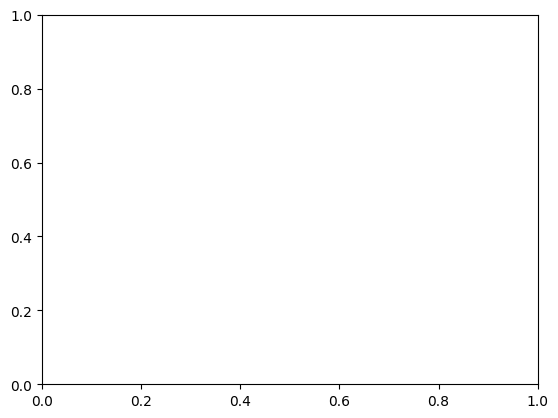

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,51)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

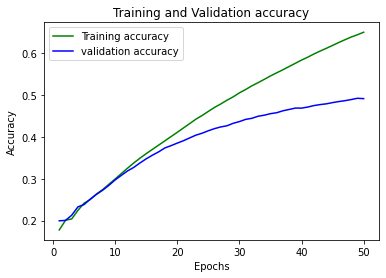

In [ ]:
loss_train = history.history['acc']
loss_val = history.history['val_acc']
epochs = range(1,51)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

### Load the weights, if you close the application

In [ ]:
model.load_weights('nmt_weights.h5')

In [ ]:
# Encode the input sequence to get the "thought vectors"
encoder_model = Model(encoder_inputs, encoder_states)

# Decoder setup
# Below tensors will hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

dec_emb2= dec_emb_layer(decoder_inputs) # Get the embeddings of the decoder sequence

# To predict the next word in the sequence, set the initial states to the states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_outputs2) # A dense softmax layer to generate prob dist. over the target vocabulary

# Final decoder model
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

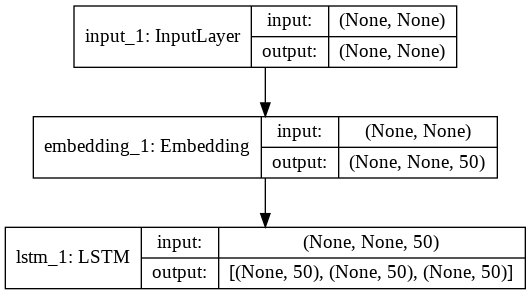

In [ ]:
Image(retina=True, filename='encoder_model.png')

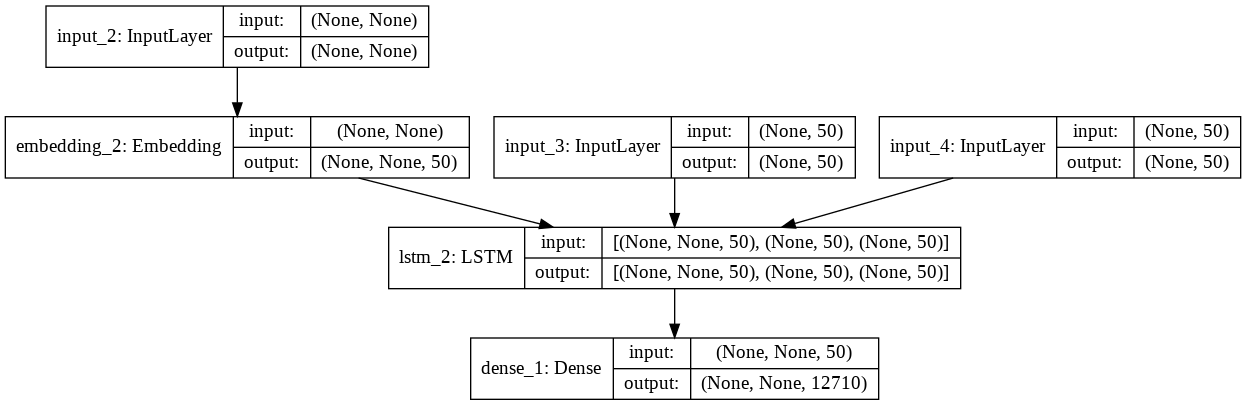

In [ ]:
Image(retina=True, filename='decoder_model.png')

### Decode sample sequeces

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = target_token_index['START_']

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += ' '+sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if (sampled_char == '_END' or
           len(decoded_sentence) > 50):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update states
        states_value = [h, c]

    return decoded_sentence

### Evaluation on Train Dataset

In [ ]:
train_gen = generate_batch(X_train, y_train, batch_size = 1)
k=-1

In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i wanted to show you first
Actual Marathi Translation:  पहिलं मला तुम्हाला दाखवायचं होतं 
Predicted Marathi Translation:  मला तुला टॉमला काही दिसलं नाहीत 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: they want to meet you
Actual Marathi Translation:  त्यांना तुम्हाला भेटायचं आहे 
Predicted Marathi Translation:  त्यांना तुला भेटायचं आहे 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i make my own rules
Actual Marathi Translation:  मी स्वतःचेच नियम बनवतो 
Predicted Marathi Translation:  मी माझा जन्म आलो आहे का 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: it was my grandfather that told me that story
Actual Marathi Translation:  मला ज्यांनी ती गोष्ट सांगितली ते म्हणजे माझे आजोबा 
Predicted Marathi Translation:  माझी गोष्ट ते माझी गोष्ट काय करतात 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i saw a woman in black
Actual Marathi Translation:  मी एका काळे कपडे घातलेल्या एका स्त्रीला पाहिलं 
Predicted Marathi Translation:  मी एका मुलीला एक बाटली लागली 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: what a big dog that is
Actual Marathi Translation:  काय मोठा कुत्रा आहे तो 
Predicted Marathi Translation:  त्याचा कुत्रा काय आहे की तो प्रसिद्ध आहे 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i am in rome now
Actual Marathi Translation:  मी आता रोममध्ये आहे 
Predicted Marathi Translation:  मी आता खेळ नाहीये 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: dont get me flowers anymore
Actual Marathi Translation:  माझ्यासाठी आतापासून फुलं आणू नकोस 
Predicted Marathi Translation:  मला अजूनही जागा आवडत नाही 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: do it somewhere else
Actual Marathi Translation:  कुठेतरी दुसरीकडे जाऊन कर 
Predicted Marathi Translation:  कुठेतरी कुठेतरी जायला काढून टाकलं आहे 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: were you really in boston
Actual Marathi Translation:  तू खरच बॉस्टनमध्ये होतीस का 
Predicted Marathi Translation:  तू खरच बॉस्टनमध्ये होतास का 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: should i tell tom
Actual Marathi Translation:  मी टॉमला सांगू का 
Predicted Marathi Translation:  टॉमला ते कोणाला हवं आहे का 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: in america we usually buy eggs by the dozen
Actual Marathi Translation:  अमेरिकेत आपण डझनाच्या हिशोबाने अंडी विकत घेतो 
Predicted Marathi Translation:  अमेरिकेत आपण डझनाच्या हिशोबाने अंडी विकत घेतली 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i caught the ball with one hand
Actual Marathi Translation:  मी एका हाताने चेंडू पकडला 
Predicted Marathi Translation:  मी बंदूक हरवली 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: they should arrive by ten oclock
Actual Marathi Translation:  ते दहा वाजेपर्यंत यायला पाहिजेत 
Predicted Marathi Translation:  ते बसने जातात 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: who needs computers
Actual Marathi Translation:  संगणक कोणाला लागतात 
Predicted Marathi Translation:  कोणाला उत्तरं आहेत 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: sri lanka is a beautiful island
Actual Marathi Translation:  श्रीलंका एक सुंदर बेट आहे 
Predicted Marathi Translation:  श्रीलंका एक सुंदर एक सुंदर आहे 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i learned that from you
Actual Marathi Translation:  ते मी तुमच्यापासून शिकले 
Predicted Marathi Translation:  मी ते जपानी राहतो ना 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i want to see your mother
Actual Marathi Translation:  मला तुमच्या आईंना बघायचं आहे 
Predicted Marathi Translation:  मला तुझ्या आईला बघायचं आहे 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: he even criticized george washington
Actual Marathi Translation:  त्यांनी तर जॉर्ज वॉशिंग्टनचीही टीका केली 
Predicted Marathi Translation:  त्याने बहुधा स्टेक आयात करतो 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: thats all we want
Actual Marathi Translation:  आम्हाला तितकंच हवं आहे 
Predicted Marathi Translation:  आम्हाला ते किती तास नाहीये 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: leave it to me
Actual Marathi Translation:  माझ्यावर सोड 
Predicted Marathi Translation:  मला सोड 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: luck had nothing to do with it
Actual Marathi Translation:  त्यात नशीबाचा हात नव्हता 
Predicted Marathi Translation:  त्यात नशीबाचा हात नकोस 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: we do everything together
Actual Marathi Translation:  आपण सगळ्या गोष्टी एकत्र करतो 
Predicted Marathi Translation:  आपण एकत्र सर्वकाही करायला 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: there are many cockroaches in the kitchen
Actual Marathi Translation:  स्वयंपाकघरात भरपूर झुरळं आहेत 
Predicted Marathi Translation:  स्वयंपाकघरात भरपूर पाणी होती 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: its only blood
Actual Marathi Translation:  रक्तच तर आहे 
Predicted Marathi Translation:  रक्तच आहे 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: we didnt get it
Actual Marathi Translation:  आम्हाला कळलं नाही 
Predicted Marathi Translation:  आपण विसरू नकोस 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: im still sick
Actual Marathi Translation:  मी अजूनही आजारी आहे 
Predicted Marathi Translation:  मी अजूनही आजारी आहे 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: tell the truth to tom
Actual Marathi Translation:  टॉमला खरं सांगा 
Predicted Marathi Translation:  टॉमला खरं सांगितलं 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: tom gave mary a dollar
Actual Marathi Translation:  टॉमने मेरीला एक डॉलर दिला 
Predicted Marathi Translation:  टॉमने मेरीला एक ग्लास पाणी घेतलं 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: this photo was taken on monday
Actual Marathi Translation:  हा फोटो सोमवारी काढलेला 
Predicted Marathi Translation:  हा फोटो सोमवारी काढलेला 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: it is under the chair
Actual Marathi Translation:  खुर्चीखाली आहे 
Predicted Marathi Translation:  खुर्चीखाली आहे 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: he deals in whiskey
Actual Marathi Translation:  ते व्हिस्कीचा व्यापार करतात 
Predicted Marathi Translation:  तो व्हिस्कीचा व्यापार करतो 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: glass is made from sand
Actual Marathi Translation:  काच वाळूपासून बनवली जाते 
Predicted Marathi Translation:  काच वाळूपासून बनवली जाते 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i met him
Actual Marathi Translation:  मी त्याला भेटलो 
Predicted Marathi Translation:  मी त्याला भेटले 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i want coffee
Actual Marathi Translation:  मला कॉफी हवी आहे 
Predicted Marathi Translation:  मला कॉफी हवी आहे 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: im already so late
Actual Marathi Translation:  मला आधीच इतका उशीर झाला आहे 
Predicted Marathi Translation:  मला फक्त किती वेळ आहे 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: which do you like better the sea or the mountains
Actual Marathi Translation:  तुला जास्त काय आवडतं समुद्र की डोंगर 
Predicted Marathi Translation:  तुला सर्वात सर्वात सर्वात कोणता खेळतात का 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: the british started to attack from across the river
Actual Marathi Translation:  ब्रिटिश नदीच्या पलीकडून हल्ला करू लागले 
Predicted Marathi Translation:  ब्रिटिश राजदूताला रमजान वापरत नाही तसाच 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: she likes all of us
Actual Marathi Translation:  तिला आपण सर्वच आवडतो 
Predicted Marathi Translation:  तिला आपल्याला बेसबॉल आवडतो 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: lets start with lesson ten
Actual Marathi Translation:  दहाव्या धड्यापासून सुरू करुया 
Predicted Marathi Translation:  वर्ग काळोख आहे 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: they accepted the new government
Actual Marathi Translation:  त्यांनी नवीन शासन स्वीकारलं 
Predicted Marathi Translation:  त्यांनी तीन महिन्यांनंतर होता 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: ill order that later
Actual Marathi Translation:  ते मी नंतर मागवेन 
Predicted Marathi Translation:  ते मी ते पत्र दिलं 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: this is toms sister
Actual Marathi Translation:  ही टॉमची बहीण आहे 
Predicted Marathi Translation:  ही टॉमची बहीण आहे 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: tom finally got what he wanted
Actual Marathi Translation:  टॉमला जे हवं होतं ते शेवटी त्याला मिळालं 
Predicted Marathi Translation:  टॉमला जे काही सांगितलं त्याला माहीत होतं 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: they said yes
Actual Marathi Translation:  त्या हो म्हणाल्या 
Predicted Marathi Translation:  ते म्हणतात 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i want something sweet to eat
Actual Marathi Translation:  मला काहीतरी गोड खायला हवंय 
Predicted Marathi Translation:  मला काहीतरी मिळेल हे मला आवडलं नाही 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: the garden was full of yellow flowers
Actual Marathi Translation:  बाग पिवळ्या फुलांनी भरलेलं 
Predicted Marathi Translation:  बाग पिवळ्या फुलांनी भरलेलं 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i dont have a smartphone
Actual Marathi Translation:  माझ्याकडे स्मार्टफोन नाहीये 
Predicted Marathi Translation:  माझ्याकडे भूक लागली नाहीये 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: we saw nothing strange
Actual Marathi Translation:  आम्हाला काही विचित्र दिसलं नाही 
Predicted Marathi Translation:  आम्हाला काहीही माहीत आहे 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: we like games
Actual Marathi Translation:  आम्हाला गेम आवडतात 
Predicted Marathi Translation:  आम्हाला खेळ आवडतात 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: there are a lot of people here today
Actual Marathi Translation:  आज भरपूर लोकं आहेत इथे 
Predicted Marathi Translation:  आज इथे भरपूर लोकं होती 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(train_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_train[k:k+1].values[0])
print('Actual Marathi Translation:', y_train[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: pakistan is a muslim country
Actual Marathi Translation:  पाकिस्तान हा मुस्लिम देश आहे 
Predicted Marathi Translation:  वाह हा मुस्लिम असतो 


### Evaluation on Validation Dataset

In [ ]:
val_gen = generate_batch(X_test, y_test, batch_size = 1)
k=-1

In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: he went instead of his dad
Actual Marathi Translation:  त्याच्या बाबांच्या जागी तो गेला 
Predicted Marathi Translation:  तो मुलगा तिथे काम अनुवाद केला 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: my favorite team lost yesterday
Actual Marathi Translation:  काल माझा आवडता संघ हरला 
Predicted Marathi Translation:  माझ्या वर्षी तुझा भाऊ बेसबॉल आवडतात 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: dont let the enemy get close
Actual Marathi Translation:  शत्रुला जवळ येऊ देऊ नकोस 
Predicted Marathi Translation:  खिडक्या उघड्या ठेवून देऊ नकोस 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: why doesnt tom talk
Actual Marathi Translation:  टॉम बोलत का नाही 
Predicted Marathi Translation:  टॉम खोटं बघायला पाहिजे 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: what can tom do that mary cant
Actual Marathi Translation:  टॉम असं काय करू शकतो जे मेरी करू शकत नाही 
Predicted Marathi Translation:  टॉम तसं करू नकोस ते खरं नव्हतं 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: tom likes french
Actual Marathi Translation:  टॉमला फ्रेंच आवडते 
Predicted Marathi Translation:  टॉमला फ्रेंच आवडते 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: the population of japan is about million
Actual Marathi Translation:  जपानची लोकसंख्या सुमारे दशलक्ष आहे 
Predicted Marathi Translation:  जपान लोकसंख्या अतिशय खेळ सुरू आहे 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i cant tell you the truth
Actual Marathi Translation:  खरं काय हे मी तुम्हाला सांगू शकत नाही 
Predicted Marathi Translation:  मी तुला खरं सांगितलं नाही का 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: im using twitter
Actual Marathi Translation:  मी ट्विटर वापरत आहे 
Predicted Marathi Translation:  मी ट्विटर आवडत नाही 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: thats not my name
Actual Marathi Translation:  ते माझं नाव नाही आहे 
Predicted Marathi Translation:  तो माझं नाव नाहीये 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: did you play tennis
Actual Marathi Translation:  टेनिस खेळलीस का 
Predicted Marathi Translation:  तू टेनिस खेळता येतो 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: this meat has gone bad
Actual Marathi Translation:  हे मांस खराब झालंय 
Predicted Marathi Translation:  हे मटण वाजता उघडतं 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i started thinking about tom
Actual Marathi Translation:  मी टॉमचा विचार करू लागले 
Predicted Marathi Translation:  मी टॉम पाऊस पडला 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: when was this car washed
Actual Marathi Translation:  ही गाडी कधी धुतली होती 
Predicted Marathi Translation:  ही ही चित्र तो कधीही थंड आहे 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: you put too much sugar in your tea
Actual Marathi Translation:  तू तुझ्या चहात खूपच साखर घालतेस 
Predicted Marathi Translation:  तू किती ड्रेस या हव्या आहेत 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i forgot to buy flowers for mary
Actual Marathi Translation:  मी मेरीसाठी फुलं आणायला विसरले 
Predicted Marathi Translation:  मी गिटार आणायला सांगतो 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: elephants have long trunks
Actual Marathi Translation:  हत्तींच्या लांब सोंडी असतात 
Predicted Marathi Translation:  मोठे सर्व मासे आवडतात 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: theyre eating sandwiches
Actual Marathi Translation:  त्या सँडविच खाताहेत 
Predicted Marathi Translation:  ते सँडविच खाताहेत 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: he lived in matsue for seven years
Actual Marathi Translation:  तो मात्सुएमध्ये सात वर्ष राहिला 
Predicted Marathi Translation:  तो सात वाजता उठतो 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: where did you see the woman
Actual Marathi Translation:  तू त्या बाईला कुठे बघितलंस 
Predicted Marathi Translation:  तुम्ही कोणी सही कुठे मिळाली 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i just need three hundred dollars
Actual Marathi Translation:  मला फक्त तीनशे डॉलरची गरज आहे 
Predicted Marathi Translation:  मला फक्त दररोजच दहा डॉलर हवी आहे 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: how many flowers do you buy
Actual Marathi Translation:  तू किती फुलं विकत घेतोस 
Predicted Marathi Translation:  किती पुस्तकं विकत घेतलंस 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: the news cant be true
Actual Marathi Translation:  ती बातमी खरी असू शकत नाही 
Predicted Marathi Translation:  बातमी बातमी नाहीये 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: president lincoln wrote all five of these documents
Actual Marathi Translation:  राष्ट्राध्यक्ष लिंकन यांनी हे पाचही दस्ताऐवज लिहिले 
Predicted Marathi Translation:  जपानमध्ये लोकं आपल्या वसाहती टाकतो 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: this is food
Actual Marathi Translation:  हे खाणं आहे 
Predicted Marathi Translation:  हे टेबल आहे 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: tom said mary used to live in australia
Actual Marathi Translation:  टॉम म्हणाला की मेरी ऑस्ट्रेलियात राहायची 
Predicted Marathi Translation:  टॉम आणि मेरी दोघेही एकत्र राहतो 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: they dont know my name
Actual Marathi Translation:  त्यांना माझं नाव माहीत नाहीये 
Predicted Marathi Translation:  टॉम तुझं नाव माहीत नाही 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: goats can eat almost anything
Actual Marathi Translation:  बकर्‍या जवळजवळ काहीही खाऊ शकतात 
Predicted Marathi Translation:  बकरे जवळजवळ काहीही खाऊ शकतं 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: rice is good with miso soup
Actual Marathi Translation:  मिसो सूपबरोबर भात चांगला लागतो 
Predicted Marathi Translation:  तुमच्या तुलनेत किती आवडतात 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: this book is really old
Actual Marathi Translation:  हे पुस्तक खरंच जुनं आहे 
Predicted Marathi Translation:  हे पुस्तक अतिशय कठीण आहे 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: we won
Actual Marathi Translation:  आपण जिंकलो 
Predicted Marathi Translation:  आपण जिंकलो 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: she has small feet
Actual Marathi Translation:  तिचे छोटे पाय आहेत 
Predicted Marathi Translation:  तिच्याकडे छोटे केस आहेत 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i dont want to sign that
Actual Marathi Translation:  मला त्यावर सही करायची नाहीये 
Predicted Marathi Translation:  मला त्या मुलींना जायचं नाहीये 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: tom still doesnt live in boston
Actual Marathi Translation:  टॉम अजूनही बॉस्टनमध्ये राहत नाही 
Predicted Marathi Translation:  टॉम अजूनही बॉस्टनमध्ये नाही होतो 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: tom was different
Actual Marathi Translation:  टॉम वेगळा होता 
Predicted Marathi Translation:  टॉम जिंकला 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: he has a camera
Actual Marathi Translation:  त्याच्याकडे कॅमेरा आहे 
Predicted Marathi Translation:  त्याच्याकडे एक कॅमेरा आहे 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i dont need to talk to tom
Actual Marathi Translation:  मला टॉमशी बोलण्याची गरज नाहीये 
Predicted Marathi Translation:  मला टॉमशी बोलायचं नाहीये 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i speak french a little bit
Actual Marathi Translation:  मला अगदी जराशी फ्रेंच बोलता येते 
Predicted Marathi Translation:  मी फ्रेंच फ्रेंच बोलता येत नाही 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: the miners did not want to fight
Actual Marathi Translation:  खाण कामगार लढू इच्छित नव्हते 
Predicted Marathi Translation:  सूर्य तर चमकत होतं नाहीतर सगळीकडे आहे 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: seven is sometimes considered a lucky number
Actual Marathi Translation:  सात हा कधीकधी नशीबवान अंक समजला जातो 
Predicted Marathi Translation:  लोकं जपानी लोकं तू राहतात का 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: tom was here all day
Actual Marathi Translation:  टॉम दिवसभर इथे होता 
Predicted Marathi Translation:  टॉम इथे इथे आलो 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: lots of italians went to australia
Actual Marathi Translation:  पुष्कळ इटालियन ऑस्ट्रेलियाला गेले 
Predicted Marathi Translation:  हे तीस जण होते की मी तीन आहेत 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: do you know toms full name
Actual Marathi Translation:  तुला टॉमचं पूर्ण नाव माहीत आहे का 
Predicted Marathi Translation:  टॉमचं नाव काय माहीत नाही का आहे 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i like your idea
Actual Marathi Translation:  मला तुझी आयडिया आवडली 
Predicted Marathi Translation:  मला तुझी मदत करू दे 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: who are you calling
Actual Marathi Translation:  कोणाला फोन करत आहेस 
Predicted Marathi Translation:  तुला कोण कोणाला आहे 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: i know tom very well
Actual Marathi Translation:  मी टॉमला अगदी बर्‍यापैकी ओळखते 
Predicted Marathi Translation:  मला अजूनही फोन करतोय 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: many americans did not have jobs
Actual Marathi Translation:  पुष्कळ अमेरिकनांकडे नोकर्‍या नव्हत्या 
Predicted Marathi Translation:  अमेरिकन देशांमध्ये देशांमध्ये लोकप्रिय आहे 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])

Input English sentence: let me come with you
Actual Marathi Translation:  मला तुझ्याबरोबर येऊ दे 
Predicted Marathi Translation:  मला आत ये 


In [ ]:
k+=1
(input_seq, actual_output), _ = next(val_gen)
decoded_sentence = decode_sequence(input_seq)
print('Input English sentence:', X_test[k:k+1].values[0])
print('Actual Marathi Translation:', y_test[k:k+1].values[0][6:-4])
print('Predicted Marathi Translation:', decoded_sentence[:-4])
BLEUscore = nltk.translate.bleu_score.sentence_bleu([decoded_sentence[:-4]], X_test[k:k+1].values[0])
print(BLEUscore)

Input English sentence: tom doesnt listen to anyone
Actual Marathi Translation:  टॉम कोणाचंही ऐकत नाही 
Predicted Marathi Translation:  टॉम कोणीही ऐकत नाही 
0.6204032394013997


/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
